In [ ]:
from fastai2.basics import *
from transformers import AutoTokenizer
from fastai_transformers_utils.all import *

from nmt_try.models.patch import *
from nmt_try.models.tran2tran import *
from nmt_try.data.news_commentary import *
from nmt_try.metrics import compute_bleu

In [ ]:
# all_skip

In [ ]:
tok_data_loc = './data/News_Commentary/tok-news-commentary-v14.en-zh.csv'
enc_model_name = 'bert-base-cased'
dec_model_name = 'hfl/chinese-bert-wwm-ext'
enc_seq_len = 100
dec_seq_len = 65

In [ ]:
enc_tokenizer = AutoTokenizer.from_pretrained(enc_model_name)
dec_tokenizer = AutoTokenizer.from_pretrained(dec_model_name)
dec_tokenizer.add_special_tokens({'bos_token': '[CLS]', 'eos_token': '[SEP]'})

0

# Try news commentary data with tran2tran model
>

## Datasets

In [ ]:
small_dss = get_nc_dss(tok_data_loc, enc_tokenizer, dec_tokenizer, enc_seq_len, dec_seq_len, pct=0.2)
dss = get_nc_dss(tok_data_loc, enc_tokenizer, dec_tokenizer, enc_seq_len, dec_seq_len)

## Model

In [ ]:
enc_max_pos_id = enc_seq_len+10
enc_vocab_size = len(enc_tokenizer)
enc_pad_id = enc_tokenizer.pad_token_id

dec_max_pos_id = dec_seq_len+10
dec_vocab_size = len(dec_tokenizer)
dec_pad_id = dec_tokenizer.pad_token_id

embeded_size = 768
num_head = 8
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 1024
drop_p = 0.1

In [ ]:
%xdel tran2tran
%xdel decoder
%xdel encoder
encoder = TranEncoder(enc_vocab_size, embeded_size, enc_max_pos_id, enc_pad_id)
decoder = TranDecoder(dec_vocab_size, embeded_size, dec_max_pos_id, dec_pad_id)
tran2tran = Tran2Tran(encoder, decoder, enc_pad_id)

## Learner and Train

In [ ]:
%xdel dls
%xdel learn
# dls = small_dss.dataloaders(bs=64)
dls = dss.dataloaders(bs=64)
learn = Learner(dls, 
                tran2tran, 
                loss_func=CrossEntropyLossFlat(ignore_index=dec_pad_id), 
                opt_func=Adam,
                metrics=[accuracy, Perplexity()],
               ).to_fp16()

(0.03630780577659607, 0.3019951581954956)

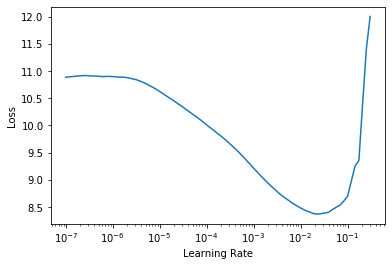

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-4)

KeyboardInterrupt: 

In [ ]:
torch.save(tran2tran.state_dict(), './models/1-nc_tran2tran.pt')

In [ ]:
tran2tran.load_state_dict(torch.load('./models/1-nc_tran2tran.pt', map_location='cuda'))

## Bleu

In [ ]:
generated_tran2tran = GeneratedTran2Tran(tran2tran, enc_tokenizer, dec_tokenizer)
generate_args = GenerateArgs(   
    max_length=65,
#     do_sample=True,
    num_beams=1,
    temperature=1.0,
#     top_k=3, 
#     top_p=0.9, 
#     repetition_penalty=5,
#     length_penalty=6,
)

In [ ]:
compute_bleu(generated_tran2tran, generate_args, dec_tokenizer, dls.valid)

## Generate

In [ ]:
generate_args = GenerateArgs(   
    max_length=65,
#     do_sample=True,
    num_beams=3,
    temperature=1.0,
#     top_k=3, 
#     top_p=0.9, 
#     repetition_penalty=5,
#     length_penalty=6,
)

In [ ]:
src_strs = [
    'They have their own vision; their own planners, architects, and engineers; and their own manpower.',
    'As demand rises, more and better jobs will be created not only in Asia, but also globally, along supply chains and across production networks.',
    'If the EU is to progress beyond the limits of a common economic and monetary policy and develop a defense and security policy along with a common foreign policy, the UK must be on board.',
    'Today, when a new strain of influenza appears in Asia, scientists collect a throat swab, isolate the virus, and run the strain’s genetic sequence.',
    'Other elements of Lee’s plan include construction of eco-friendly transportation networks, such as high-speed railways and hundreds of kilometers of bicycle tracks, and generating energy using waste methane from landfills.',

]
tgt_strs = [
    '他们有自己的愿景，自己的规划师、建筑师和工程师，自己的劳动力。',
    '随着需求不断攀升，不仅亚洲会创造出更多更好的就业机会，全球范围内的供应链及整个生产网络也将会从中受益。',
    '如果欧盟想要突破共同的经济和货币政策的界限，在发展安全防卫政策的同时发展共同的外交政策，英国必须参与。',
    '如今，当新的流感菌株在亚洲出现时，科学家收集咽喉棉签，分离病毒，测定毒株的基因序列。',
    '李总统计划的其他要素还包括建设生态友好的运输网络，例如高速铁路以及几百公里长的自行车车道，并且从垃圾堆中利用甲烷来制造能源。',
]

In [ ]:
result = generated_tran2tran.generate_from_strs(src_strs, generate_args, device='cuda:0')
result

['They must be able to be able to ensure that they must be able to ensure that they',
 'The world’s energy sector is not just the world’s largest energy,',
 'The EU’s leaders must be able to pursue the EU’s economic and',
 'For example, the world’s most recent population is the world’s most',
 'For example, the government’s government has been able to use the public’']